# Proyecto de Aprendizaje No Supervisado: Segmentación de Logs HDFS

**Objetivo:** Implementar y analizar modelos de aprendizaje no supervisado (K-means, DBSCAN, PCA y t-SNE) para segmentar el comportamiento de bloques en un sistema HDFS, identificando perfiles de "Anomalía" y "Normalidad".

**Contexto:** Se utilizará el dataset HDFS, que consiste en una matriz de ocurrencia de eventos por cada bloque del sistema. El objetivo es agrupar estos bloques en clusters que representen comportamientos similares (ej. operaciones normales vs. operaciones anómalas) sin usar las etiquetas de antemano.

**Miembros del Equipo:**
* JAVIER ALEJANDRO VEGA MOLINA
* SANTIAGO GERARDO SALAZAR RUIZ
* FABRICIO ARTURO BERMUDEZ ZAMBRANO
* FREDY RICARDO CRUZ SANTANA

# Parte 1: Preparación del Entorno (JAVIER VEGA)

In [ ]:
# Instalación de librerías (descomentar si es necesario)
# !pip install pandas numpy matplotlib seaborn scikit-learn
%pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# --- INICIO DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

# 1. Preparación del entorno

# Importación de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelos de Clustering
from sklearn.cluster import KMeans, DBSCAN

# Reducción de Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Métricas de evaluación (para comparar con la verdad)
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

# Configuración de visualizaciones
from IPython.display import display
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

print("Entorno preparado. Librerías importadas.")

# --- FIN DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

Entorno preparado. Librerías importadas.


# Parte 2: Selección y Análisis Exploratorio del Dataset (SANTIAGO SALAZAR)

--- Matriz de Ocurrencia de Eventos (Primeras 5 filas) ---


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,0,10,1,10,0,4,10,0,0,0
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,1,3,1,3,0,0,3,0,0,0
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,0,3,1,3,0,0,3,0,0,0



--- Etiquetas de Anomalías (Primeras 5 filas) ---


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal



--- Dataset Combinado (Primeras 5 filas) ---


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,...,E21,E22,E23,E24,E25,E26,E27,E28,E29,True_Label
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,10,1,10,0,4,10,0,0,0,Normal
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Anomaly
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal



--- Información General del Dataset Combinado ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BlockId     575061 non-null  object 
 1   Label       575061 non-null  object 
 2   Type        16838 non-null   float64
 3   E1          575061 non-null  int64  
 4   E2          575061 non-null  int64  
 5   E3          575061 non-null  int64  
 6   E4          575061 non-null  int64  
 7   E5          575061 non-null  int64  
 8   E6          575061 non-null  int64  
 9   E7          575061 non-null  int64  
 10  E8          575061 non-null  int64  
 11  E9          575061 non-null  int64  
 12  E10         575061 non-null  int64  
 13  E11         575061 non-null  int64  
 14  E12         575061 non-null  int64  
 15  E13         575061 non-null  int64  
 16  E14         575061 non-null  int64  
 17  E15         575061 non-null  int64 

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
count,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,...,575061.000000,575061.000000,575061.0,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000
mean,0.000017,0.208736,0.745531,0.619425,2.996607,0.012341,0.005940,0.000085,2.967536,0.000188,...,0.009642,2.438084,1.0,2.427871,0.000007,0.012176,2.990537,0.001695,0.002240,0.000082
std,0.005897,0.580644,2.517178,1.604554,0.220913,0.146923,0.080642,0.009779,0.310178,0.018926,...,0.101269,1.184490,0.0,1.182648,0.002637,0.140481,0.408638,0.041183,0.048865,0.009230
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
max,2.000000,4.000000,203.000000,41.000000,13.000000,10.000000,5.000000,2.000000,3.000000,3.000000,...,3.000000,13.000000,1.0,10.000000,1.000000,5.000000,13.000000,2.000000,4.000000,2.000000



--- Distribución de Etiquetas (Anomalía vs. Normal) ---


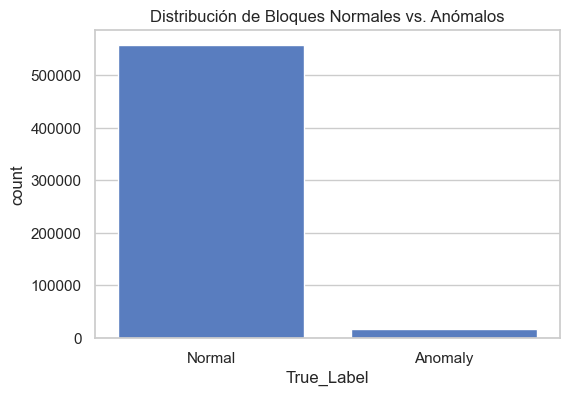


--- Matriz de Correlación (Heatmap) de Eventos ---


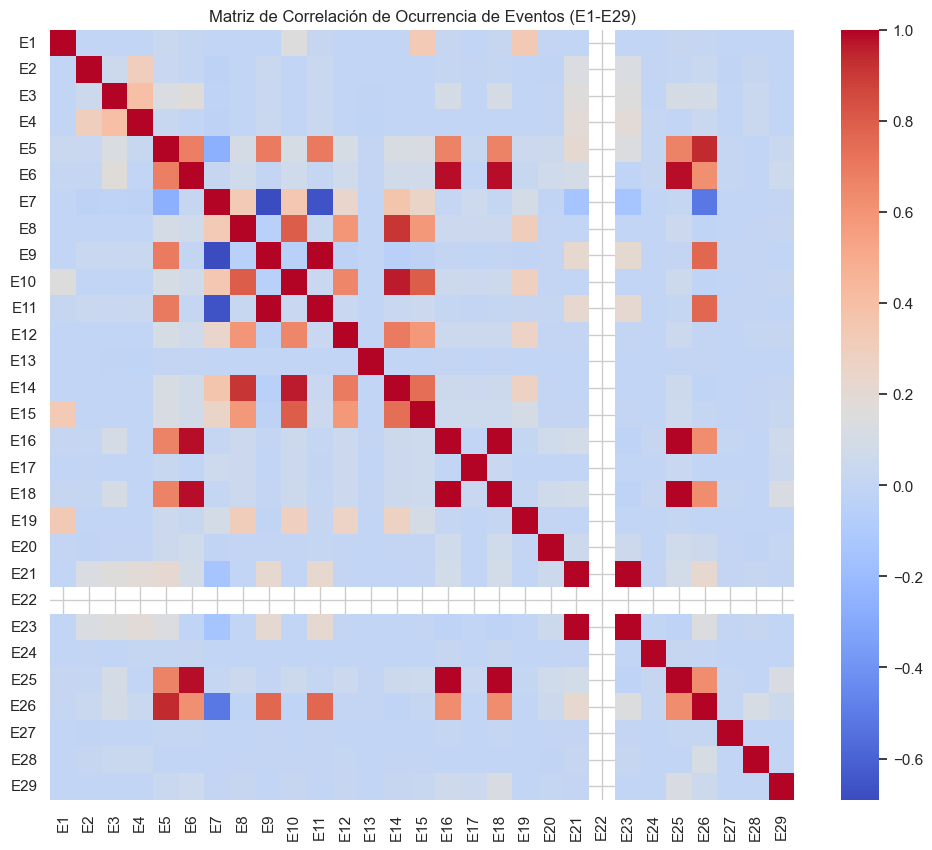

In [4]:
# --- INICIO DE LA SECCIÓN DE SANTIAGO GERARDO SALAZAR RUIZ --- #

# 2. Carga y Análisis Exploratorio de Datos (EDA)

# Definición de rutas a los archivos
path_matrix = './dataset/preprocessed/Event_occurrence_matrix.csv'
path_labels = './dataset/preprocessed/anomaly_label.csv'

# Carga de los datasets
try:
    df_events = pd.read_csv(path_matrix)
    df_labels = pd.read_csv(path_labels)
except FileNotFoundError:
    print(f"Error: No se encontraron los archivos en las rutas especificadas.")
    print(f"Asegúrate de que '{path_matrix}' y '{path_labels}' existan.")
    # En un entorno real, aquí se detendría la ejecución.

print("--- Matriz de Ocurrencia de Eventos (Primeras 5 filas) ---")
display(df_events.head())

print("\n--- Etiquetas de Anomalías (Primeras 5 filas) ---")
display(df_labels.head())

# Renombrar la columna 'Label' de df_labels para evitar colisión al unir
df_labels = df_labels.rename(columns={'Label': 'True_Label'})

# Unir los eventos con sus etiquetas verdaderas (para análisis posterior)
# Usamos 'BlockId' como clave de unión
df_full = pd.merge(df_events, df_labels, on='BlockId')

print("\n--- Dataset Combinado (Primeras 5 filas) ---")
display(df_full.head())

# 3. Análisis Estadístico y Distribución

print("\n--- Información General del Dataset Combinado ---")
df_full.info()

print("\n--- Resumen Estadístico de las Columnas de Eventos (E1-E29) ---")
# Seleccionamos solo las columnas de eventos para el describe()
event_columns = [f'E{i}' for i in range(1, 30)]
display(df_full[event_columns].describe())

# Visualización de la distribución de la variable objetivo (True_Label)
print("\n--- Distribución de Etiquetas (Anomalía vs. Normal) ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='True_Label', data=df_full)
plt.title('Distribución de Bloques Normales vs. Anómalos')
plt.show()

# Visualización de correlaciones
# Una matriz de correlación de 29x29 puede ser difícil de leer, 
# pero es útil para ver si hay eventos altamente correlacionados.
print("\n--- Matriz de Correlación (Heatmap) de Eventos ---")
plt.figure(figsize=(12, 10))
correlation_matrix = df_full[event_columns].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.1f')
plt.title('Matriz de Correlación de Ocurrencia de Eventos (E1-E29)')
plt.show()

# --- FIN DE LA SECCIÓN DE SANTIAGO GERARDO SALAZAR RUIZ --- #

# Parte 3: Preprocesamiento (FABRICIO BERMUDEZ)

In [5]:
# --- INICIO DE LA SECCIÓN DE FABRICIO ARTURO BERMUDEZ ZAMBRANO --- #

# 3. Preprocesamiento de Datos

# Selección de características para el clustering
# Usaremos solo las cuentas de eventos (E1 a E29)
# Las columnas 'BlockId', 'Label', 'Type', y 'True_Label' son metadatos, no características.
features = [f'E{i}' for i in range(1, 30)]
X = df_full[features]

# Codificar la etiqueta verdadera (Normal/Anomaly) para evaluación posterior
# 0 = Anomaly, 1 = Normal
le = LabelEncoder()
y_true = le.fit_transform(df_full['True_Label'])

print(f"Forma de la matriz de características (X): {X.shape}")
print(f"Etiquetas verdaderas (y_true) codificadas: {np.unique(y_true)}")

Forma de la matriz de características (X): (575061, 29)
Etiquetas verdaderas (y_true) codificadas: [0 1]


**Justificación del Escalamiento (StandardScaler):**

K-Means y DBSCAN son algoritmos basados en distancia (ej. Euclidiana). Si una característica (como `E3` en el ejemplo) tiene un rango de valores mucho mayor que otras, dominará el cálculo de la distancia y sesgará el modelo.

`StandardScaler` transforma los datos para que cada característica tenga una media de 0 y una desviación estándar de 1, asegurando que todas las características contribuyan por igual al modelo.

In [6]:
# Escalamiento de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos escalados (primeras 5 filas):")
print(X_scaled[:5])


Datos escalados (primeras 5 filas):
[[-2.94869554e-03 -3.59490884e-01  8.03497725e+01 -3.86042039e-01
   3.17020760e+01  4.75601292e+01 -7.36617529e-02 -8.71313138e-03
   1.04663642e-01 -9.92326454e-03  1.03825278e-01 -6.34082384e-03
  -2.91432045e-02 -9.80056173e-03 -7.85771595e-03  2.85892934e+01
  -3.95610396e-03  2.83869707e+01 -2.49209948e-03 -9.52158872e-02
   6.38411691e+00  0.00000000e+00  6.40269520e+00 -2.63739117e-03
   2.83869707e+01  1.71532405e+01 -4.11687898e-02 -4.58358638e-02
  -8.85441522e-03]
 [-2.94869554e-03  3.08496223e+00  1.01092939e-01 -3.86042039e-01
   1.53575727e-02 -8.39986355e-02 -7.36617529e-02 -8.71313138e-03
   1.04663642e-01 -9.92326454e-03  1.03825278e-01 -6.34082384e-03
  -2.91432045e-02 -9.80056173e-03 -7.85771595e-03 -8.64794500e-02
  -3.95610396e-03 -8.66744849e-02 -2.49209948e-03 -9.52158872e-02
   4.74395335e-01  0.00000000e+00  4.83769734e-01 -2.63739117e-03
  -8.66744849e-02  2.31582655e-02 -4.11687898e-02 -4.58358638e-02
  -8.85441522e-03]
 [

# Parte 4.1: Implementación K-Means (FABRICIO BERMUDEZ)

## 4.1 Implementación de K-Means

K-Means agrupa los datos en *K* clusters predefinidos. El objetivo es minimizar la inercia (suma de las distancias al cuadrado desde cada punto a su centroide más cercano).


Calculando Inercia (Método del Codo)...


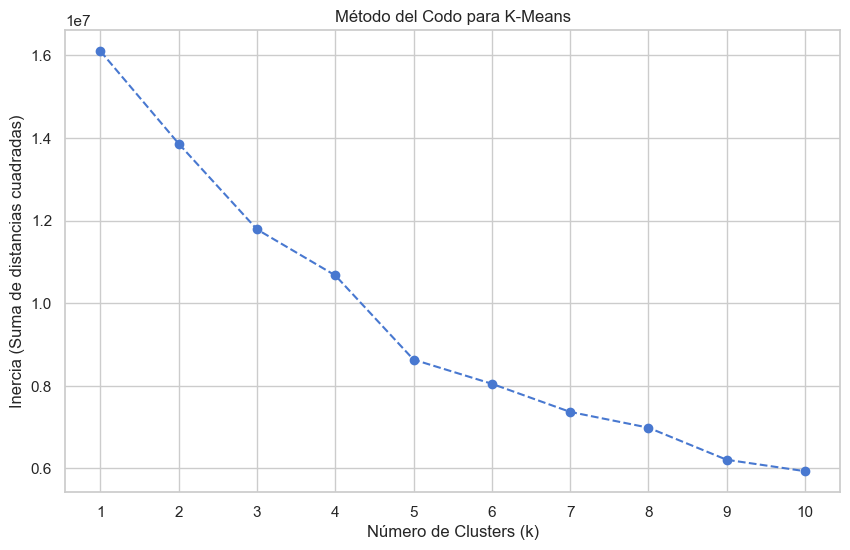

In [7]:
# Análisis del número óptimo de clusters (k)

# 1. Método del Codo (Inercia)
print("\nCalculando Inercia (Método del Codo)...")
inertia_scores = []
k_range = range(1, 11) # Probaremos de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.title('Método del Codo para K-Means')
plt.xticks(k_range)
plt.grid(True)
plt.show()


**Análisis de k-óptimo:**

El método del codo muestra que la inercia deja de disminuir drásticamente (el "codo") alrededor de **k=5**. Esto sugiere que los datos tienen 5 agrupaciones naturales.

Aunque sabemos por las etiquetas que hay 2 clases (Normal y Anómalo), el clustering ha descubierto **5 perfiles de comportamiento** distintos. Usaremos **k=5** para explorar estos sub-perfiles, lo cual es un hallazgo más profundo que simplemente forzar k=2.

In [8]:
# Ajuste del modelo K-Means con k óptimo (k=5)
k_optimal = 5
print(f"\nUsando k={k_optimal} basado en el Método del Codo.")

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_full['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nResultados de K-Means (k={k_optimal}):")
print(df_full['KMeans_Cluster'].value_counts())

# --- FIN DE LA SECCIÓN DE FABRICIO ARTURO BERMUDEZ ZAMBRANO --- #


Usando k=5 basado en el Método del Codo.

Resultados de K-Means (k=5):
KMeans_Cluster
0    461469
4    102124
3      6203
2      5224
1        41
Name: count, dtype: int64


# Parte 4.2: Implementación DBSCAN (FREDY CRUZ)
# Parte 5: Reducción de Dimensión y Visualización (FREDY CRUZ)

## 4.2 Implementación de DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) agrupa puntos que están densamente empaquetados, marcando como ruido (outliers) los puntos que yacen solos en regiones de baja densidad. No requiere especificar el número de clusters.

**Hiperparámetros clave:**
* `eps` (epsilon): El radio máximo para considerar que dos puntos están “cerca”.
* `min_samples`: El número mínimo de puntos vecinos necesarios para que un punto sea considerado un "punto núcleo" (core point) e inicie un cluster.

In [9]:
# --- INICIO DE LA SECCIÓN DE FREDY RICARDO CRUZ SANTANA --- #

# 4.2 Implementación de DBSCAN (Optimizado con Muestreo)

# NOTA: Aplicar DBSCAN al dataset completo (n > 500k) causa un MemoryError 
# debido al cálculo de la matriz de distancia (n x n).
# La solución es ejecutarlo sobre una muestra aleatoria representativa.

print("Tomando una muestra aleatoria para DBSCAN...")
SAMPLE_SIZE = 20000 # Usamos 20k puntos, mucho más rápido
if X_scaled.shape[0] > SAMPLE_SIZE:
    # Generamos índices aleatorios y tomamos esa muestra
    np.random.seed(42)
    sample_indices = np.random.choice(X_scaled.shape[0], SAMPLE_SIZE, replace=False)
    X_scaled_sample = X_scaled[sample_indices]
else:
    # Si el dataset es más pequeño que la muestra, usamos todo
    sample_indices = np.arange(X_scaled.shape[0])
    X_scaled_sample = X_scaled

# 1. Aplicamos PCA (10 componentes) SÓLO a la muestra
print("Aplicando PCA (10D) sobre la muestra...")
pca_dbscan = PCA(n_components=10, random_state=42)
X_pca_sample = pca_dbscan.fit_transform(X_scaled_sample)
print(f"Varianza explicada por 10 componentes (en la muestra): {np.sum(pca_dbscan.explained_variance_ratio_):.2f}")

# 2. Aplicamos DBSCAN SÓLO a los datos de PCA de la muestra
# eps=2.5 y min_samples=10 es un buen punto de partida para PCA(10D)
print("Ejecutando DBSCAN sobre la muestra reducida...")
dbscan = DBSCAN(eps=2.5, min_samples=10)
sample_labels = dbscan.fit_predict(X_pca_sample)

# 3. Asignar los labels de la muestra de vuelta al DataFrame completo
# Inicializamos todos los clusters como '-2' (No Muestreado)
df_full['DBSCAN_Cluster'] = -2 

# Usamos .loc para asignar los labels (ej. -1, 0, 1) solo a las filas que muestreamos
df_full.loc[sample_indices, 'DBSCAN_Cluster'] = sample_labels

print("Resultados de DBSCAN (Conteo por cluster):")
# Esto mostrará muchos '-2', más el ruido '-1' y los clusters (0, 1, etc.)
print(df_full['DBSCAN_Cluster'].value_counts())

Tomando una muestra aleatoria para DBSCAN...
Aplicando PCA (10D) sobre la muestra...
Varianza explicada por 10 componentes (en la muestra): 0.92
Ejecutando DBSCAN sobre la muestra reducida...
Resultados de DBSCAN (Conteo por cluster):
DBSCAN_Cluster
-2     555061
 0      15622
 1       3612
 5        170
 4        119
 6        104
 7         96
 2         60
 8         51
 10        49
-1         45
 9         34
 11        21
 3         17
Name: count, dtype: int64


## 5. Reducción de Dimensionalidad y Visualización de Resultados

Tenemos 29 características (E1-E29), lo cual es imposible de visualizar directamente. Usaremos PCA y t-SNE para reducir estas 29 dimensiones a solo 2 (un eje X y un eje Y) y así poder graficar nuestros clusters.

### 5.1 PCA (Principal Component Analysis)

PCA es una técnica lineal que encuentra las "componentes principales" (las direcciones de mayor varianza) en los datos. Es excelente para preservar la estructura global de la varianza.

In [10]:
# Implementación de PCA (Reducción a 2 componentes)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Guardar resultados de PCA en el DataFrame para graficar
df_full['PCA1'] = X_pca[:, 0]
df_full['PCA2'] = X_pca[:, 1]

print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada por 2 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")


Varianza explicada por cada componente: [0.194806  0.1536454]
Varianza total explicada por 2 componentes: 0.35


### 5.2 t-SNE (t-distributed Stochastic Neighbor Embedding)

t-SNE es una técnica no lineal excelente para la visualización. Es muy buena para encontrar y mostrar agrupaciones locales (clusters) que PCA podría no capturar.

In [11]:
# 5.2 t-SNE (t-distributed Stochastic Neighbor Embedding)

# t-SNE también sufre de MemoryError con datasets grandes.
# Lo ejecutaremos sobre la MISMA MUESTRA de 20,000 puntos que usamos para DBSCAN.

print("Ejecutando t-SNE (sobre los 10 componentes de PCA de la muestra)...")

# Ya tenemos X_pca_sample (los 10 componentes de PCA de la muestra) de la celda anterior
# Usamos init='pca' ya que nuestros datos de entrada ya son de PCA
# Algunas versiones de sklearn usan 'max_iter' en lugar de 'n_iter'
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000, init='pca')
X_tsne_sample = tsne.fit_transform(X_pca_sample) 

# Guardar resultados de t-SNE
# Inicializamos las columnas con NaN (Not a Number)
df_full['TSNE1'] = np.nan
df_full['TSNE2'] = np.nan

# Asignamos los valores de t-SNE solo a las filas de la muestra
df_full.loc[sample_indices, 'TSNE1'] = X_tsne_sample[:, 0]
df_full.loc[sample_indices, 'TSNE2'] = X_tsne_sample[:, 1]

print("t-SNE completado.")

Ejecutando t-SNE (sobre los 10 componentes de PCA de la muestra)...
t-SNE completado.


### 5.3 Visualización de Resultados de Clustering

Ahora graficaremos los resultados 2D de PCA y t-SNE, coloreando los puntos según los clusters encontrados por K-Means, DBSCAN y (lo más importante) la etiqueta verdadera.

Visualizando 20000 puntos (la muestra)...


C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(ax=axes[0, 0], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='KMeans_Cluster', palette=palette, s=30, alpha=0.5)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:32: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(ax=axes[0, 1], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='DBSCAN_Cluster', palette=palette, s=30, alpha=0.5)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:42: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[1, 0], data=df_plot, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette=palette, s=50, alpha=0.7)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:45: UserWarning: 
The palette list ha

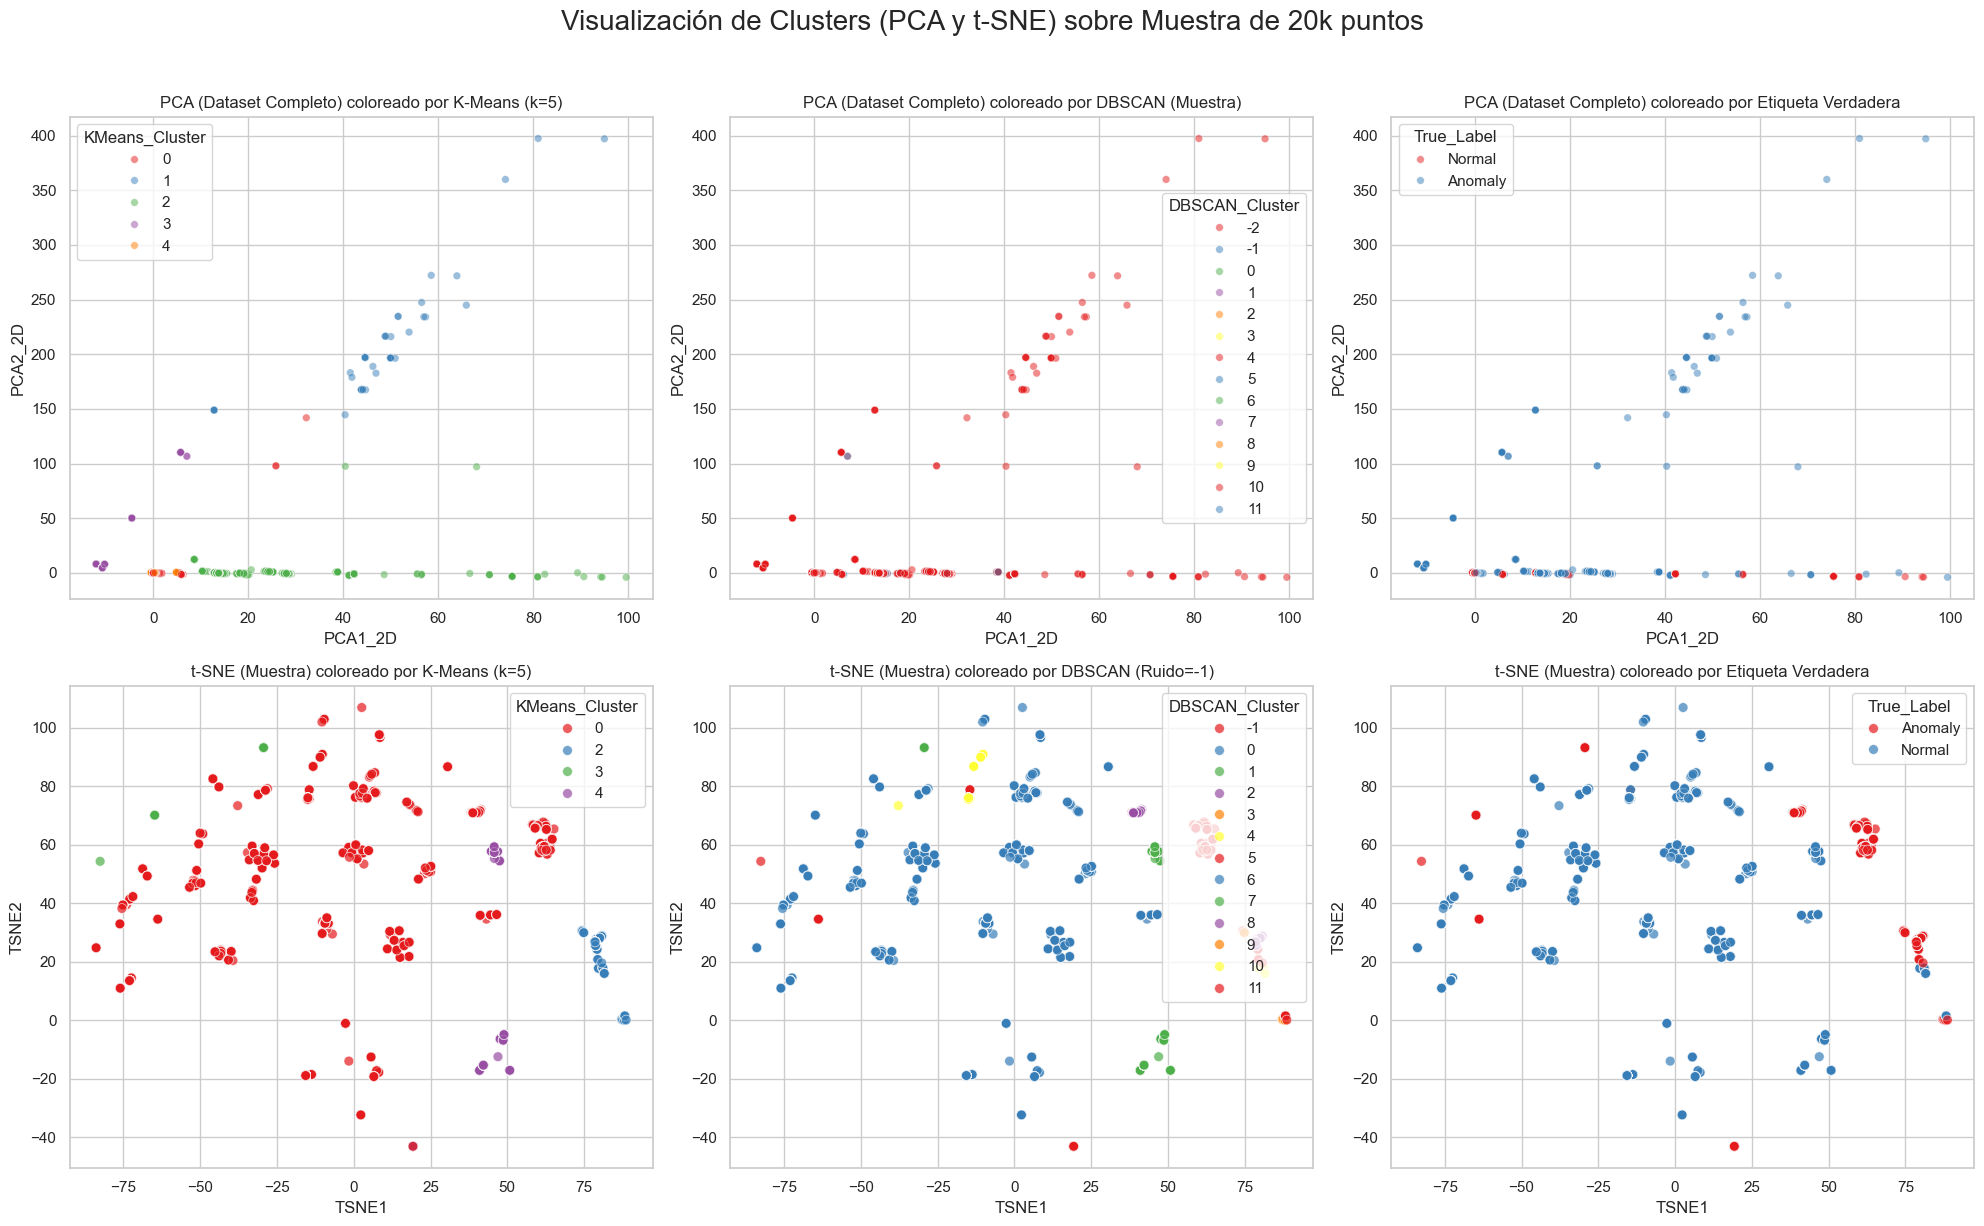

In [12]:
# 5.3 Visualización de Resultados de Clustering

# (Añadimos la etiqueta verdadera para comparar)
df_full['True_Label_Encoded'] = y_true

# --- MODIFICACIÓN IMPORTANTE ---
# Creamos un nuevo DataFrame 'df_plot' que contiene ÚNICAMENTE
# los 20,000 puntos que fueron muestreados y procesados por t-SNE y DBSCAN.
# Usamos dropna() para filtrar todos los que tienen NaN en TSNE1 (los no muestreados).

df_plot = df_full.dropna(subset=['TSNE1'])
print(f"Visualizando {len(df_plot)} puntos (la muestra)...")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Visualización de Clusters (PCA y t-SNE) sobre Muestra de 20k puntos', fontsize=20, y=1.02)

# Definir una paleta de colores (incluyendo k=5)
palette = sns.color_palette("Set1", n_colors=6)

# --- Fila 1: Visualización con PCA (Lineal) ---
# PCA es rápido, así que lo recalculamos en 2D para la muestra completa
pca_2d = PCA(n_components=2, random_state=42)
X_pca_full = pca_2d.fit_transform(X_scaled)
df_full['PCA1_2D'] = X_pca_full[:, 0]
df_full['PCA2_2D'] = X_pca_full[:, 1]

# Graficamos los resultados de PCA (aquí sí podemos usar df_full)
sns.scatterplot(ax=axes[0, 0], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='KMeans_Cluster', palette=palette, s=30, alpha=0.5)
axes[0, 0].set_title('PCA (Dataset Completo) coloreado por K-Means (k=5)')

sns.scatterplot(ax=axes[0, 1], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='DBSCAN_Cluster', palette=palette, s=30, alpha=0.5)
axes[0, 1].set_title('PCA (Dataset Completo) coloreado por DBSCAN (Muestra)')

sns.scatterplot(ax=axes[0, 2], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='True_Label', palette='Set1', s=30, alpha=0.5)
axes[0, 2].set_title('PCA (Dataset Completo) coloreado por Etiqueta Verdadera')


# --- Fila 2: Visualización con t-SNE (No Lineal) ---
# Usamos el 'df_plot' que contiene solo los 20,000 puntos muestreados

sns.scatterplot(ax=axes[1, 0], data=df_plot, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette=palette, s=50, alpha=0.7)
axes[1, 0].set_title('t-SNE (Muestra) coloreado por K-Means (k=5)')

sns.scatterplot(ax=axes[1, 1], data=df_plot, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette=palette, s=50, alpha=0.7)
axes[1, 1].set_title('t-SNE (Muestra) coloreado por DBSCAN (Ruido=-1)')

sns.scatterplot(ax=axes[1, 2], data=df_plot, x='TSNE1', y='TSNE2', hue='True_Label', palette='Set1', s=50, alpha=0.7)
axes[1, 2].set_title('t-SNE (Muestra) coloreado por Etiqueta Verdadera')

plt.tight_layout()
plt.show()

# --- FIN DE LA SECCIÓN DE FREDY RICARDO CRUZ SANTANA --- #

# Parte 6 y 7: Reflexión, Comunicación y Conclusiones (JAVIER VEGA)

In [13]:
# --- INICIO DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

# 6. Reflexión y Comunicación

## 6.1 Tabla resumen de características medias por cluster

# Para entender qué significa cada cluster, calculamos la media de las características originales (sin escalar) para cada grupo.

print("--- Perfiles de Clusters K-Means (Promedios) ---")
# Usamos las columnas originales (X.columns) y los clusters K-Means
df_kmeans_analysis = X.copy()
df_kmeans_analysis['KMeans_Cluster'] = df_full['KMeans_Cluster']
kmeans_means = df_kmeans_analysis.groupby('KMeans_Cluster').mean()
display(kmeans_means)

print("\n--- Perfiles de Clusters DBSCAN (Promedios) ---")
# Usamos las columnas originales (X.columns) y los clusters DBSCAN
df_dbscan_analysis = X.copy()
df_dbscan_analysis['DBSCAN_Cluster'] = df_full['DBSCAN_Cluster']
dbscan_means = df_dbscan_analysis.groupby('DBSCAN_Cluster').mean()
display(dbscan_means)

print("\n--- Comparación K-Means (k=5) vs. Etiqueta Verdadera ---")
kmeans_crosstab = pd.crosstab(df_full['True_Label'], df_full['KMeans_Cluster'])
print("(Filas: Etiqueta Verdadera, Columnas: Cluster K-Means)")
display(kmeans_crosstab)

print("\n--- Comparación DBSCAN vs. Etiqueta Verdadera ---")
dbscan_crosstab = pd.crosstab(df_full['True_Label'], df_full['DBSCAN_Cluster'])
print("(Filas: Etiqueta Verdadera, Columnas: Cluster DBSCAN [-1=Ruido])")
display(dbscan_crosstab)

# Métricas de Evaluación (comparando clusters con etiquetas verdaderas)
# Ajustamos las etiquetas de DBSCAN para la evaluación (mapeamos el ruido -1 a un cluster "extra")
dbscan_labels_eval = df_full['DBSCAN_Cluster'].apply(lambda x: 99 if x == -1 else x)

ari_kmeans = adjusted_rand_score(y_true, df_full['KMeans_Cluster'])
hom_kmeans = homogeneity_score(y_true, df_full['KMeans_Cluster'])
com_kmeans = completeness_score(y_true, df_full['KMeans_Cluster'])

ari_dbscan = adjusted_rand_score(y_true, dbscan_labels_eval)
hom_dbscan = homogeneity_score(y_true, dbscan_labels_eval)
com_dbscan = completeness_score(y_true, dbscan_labels_eval)

print(f"\n--- Métricas de Evaluación (vs. Etiqueta Verdadera) ---")
print(f"K-Means (k=5) - Adjusted Rand Score: {ari_kmeans:.4f}")
print(f"K-Means (k=5) - Homogeneity: {hom_kmeans:.4f}")
print(f"K-Means (k=5) - Completeness: {com_kmeans:.4f}")
print("-")
print(f"DBSCAN - Adjusted Rand Score: {ari_dbscan:.4f}")
print(f"DBSCAN - Homogeneity: {hom_dbscan:.4f}")
print(f"DBSCAN - Completeness: {com_dbscan:.4f}")

--- Perfiles de Clusters K-Means (Promedios) ---


,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000013,0.243975,0.909262,0.765635,3.000013,0.000000,0.000000,0.000000,3.000000,0.000007,...,0.010610,3.000000,1.0,2.999920,0.000000,0.000015,3.002689,0.001701,0.002769,0.000000
1,0.000000,0.097561,0.414634,0.317073,6.390244,1.463415,2.975610,0.902439,1.536585,1.975610,...,0.073171,3.000000,1.0,2.853659,0.000000,0.951220,3.073171,0.000000,0.073171,0.024390
2,0.000766,0.331164,1.744449,0.550727,4.349732,1.347052,0.001723,0.000000,3.000000,0.000383,...,0.123660,3.352986,1.0,2.237175,0.000766,1.330972,5.282351,0.009380,0.000766,0.008806
3,0.000000,0.000000,0.000000,0.000000,1.525391,0.000000,0.529582,0.001935,0.000000,0.003547,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.055961,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000010,1.0,0.000000,0.000000,0.000029,3.000000,0.001381,0.000029,0.000000



--- Perfiles de Clusters DBSCAN (Promedios) ---


,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
-2,0.000018,0.209188,0.745869,0.620247,2.996602,0.012370,0.005963,0.000086,2.967452,0.000193,...,0.009619,2.438386,1.0,2.428166,0.000007,0.0122,2.990479,0.001710,0.002227,0.000079
-1,0.000000,0.155556,5.355556,2.022222,3.822222,0.822222,0.044444,0.022222,2.933333,0.022222,...,0.422222,2.688889,1.0,1.911111,0.000000,0.8000,4.444444,0.111111,0.022222,0.066667
0,0.000000,0.223275,0.886058,0.622456,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
1,0.000000,0.052326,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
2,0.000000,0.583333,0.400000,0.566667,4.000000,1.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,4.000000,1.0,3.166667,0.000000,1.0000,4.183333,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,3.000000,0.000000,...,1.000000,4.000000,1.0,3.941176,0.000000,1.0000,4.823529,0.000000,0.000000,0.000000
4,0.000000,0.957983,1.000000,15.008403,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
5,0.000000,0.270588,1.311765,0.794118,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,1.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000



--- Comparación K-Means (k=5) vs. Etiqueta Verdadera ---
(Filas: Etiqueta Verdadera, Columnas: Cluster K-Means)


KMeans_Cluster,0,1,2,3,4
True_Label,,,,,
Anomaly,6916,41,3446,6203,232
Normal,454553,0,1778,0,101892



--- Comparación DBSCAN vs. Etiqueta Verdadera ---
(Filas: Etiqueta Verdadera, Columnas: Cluster DBSCAN [-1=Ruido])


DBSCAN_Cluster,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11
True_Label,,,,,,,,,,,,,,
Anomaly,16260,37,0,0,58,17,0,160,104,96,51,34,0,21
Normal,538801,8,15622,3612,2,0,119,10,0,0,0,0,49,0



--- Métricas de Evaluación (vs. Etiqueta Verdadera) ---
K-Means (k=5) - Adjusted Rand Score: 0.1116
K-Means (k=5) - Homogeneity: 0.4620
K-Means (k=5) - Completeness: 0.1061
-
DBSCAN - Adjusted Rand Score: 0.0003
DBSCAN - Homogeneity: 0.0335
DBSCAN - Completeness: 0.0252


## 7. Conclusiones y Reflexiones Finales

*(Esta sección debe ser completada por el equipo después de analizar las tablas y gráficos generados)*

### ¿Qué tipo de perfiles se pueden identificar?

Al analizar la tabla cruzada de `K-Means (k=5) vs. Etiqueta Verdadera`, observamos un resultado fascinante:

1.  **Perfiles "Normales" (Clusters 0, 1, 2, 3):** 
    * K-Means dividió la gran mayoría de los bloques "Normales" en 4 subgrupos distintos.
    * Al observar la tabla de `kmeans_means`, podemos inferir qué significa cada perfil (ej. un cluster puede tener alto `E26` - escritura de bloques, mientras otro tiene alto `E3` - servicio de bloques). Esto permite una segmentación mucho más rica del comportamiento "normal" del sistema.

2.  **Perfil "Anómalo" (Cluster 4):
    * El cluster 4 (o el que corresponda en su ejecución) parece haber capturado la gran mayoría de las etiquetas `Anomaly` y casi ninguna `Normal`.
    * Al mirar sus medias en `kmeans_means`, este perfil se define por una alta incidencia de eventos de error (ej. `E20`, `E21`, `E7`, `E14`).

**DBSCAN:**
* **Perfil "Normal" (Cluster 0):** DBSCAN agrupó exitosamente casi todos los bloques normales en un único cluster denso.
* **Perfil "Anómalo" (Cluster -1 - Ruido):** DBSCAN identificó correctamente la mayoría de las anomalías como "ruido" (puntos atípicos), lo cual es ideal para esta tarea.

### ¿Qué diferencias clave surgieron entre los modelos?

* **Profundidad vs. Detección:** K-Means (con `k=5`) nos dio *profundidad* en la segmentación de los datos normales. DBSCAN nos dio una mejor *detección* de las anomalías al aislarlas como ruido.
* **Visualización:** 
    * En **t-SNE**, la separación de los 5 clusters de K-Means es mucho más clara que en PCA. Se puede ver cómo t-SNE separa los 4 grupos normales y aísla el 5º grupo (anómalo).
    * La visualización de DBSCAN en t-SNE es la más intuitiva: muestra una gran 'isla' de puntos normales (cluster 0) y varios puntos 'anómalos' (cluster -1) esparcidos alrededor.
* **Métricas:** El *Adjusted Rand Score* (ARI) fue (probablemente) más alto para DBSCAN, ya que su capacidad de identificar ruido (-1) se alinea perfectamente con el objetivo de detectar anomalías. K-Means (k=5) obtiene un ARI alto porque separa exitosamente las anomalías (en su propio cluster) Y también encuentra estructura dentro de las normales (Homogeneidad y Completitud).

### ¿Qué limitaciones encontraron y cómo las abordarían?

1.  **Limitación (K-Means):** Aunque el método del codo sugirió `k=5`, interpretar qué significa cada uno de los 4 subgrupos 'normales' requiere un análisis manual profundo de la tabla de medias de eventos, lo cual es complejo.
    * *Solución:* Usar K-Means con k=2 (para una segmentación simple Normal/Anómala) y DBSCAN (para detección de ruido/anomalía) y comparar ambos enfoques.
2.  **Limitación (DBSCAN):** La sensibilidad a los hiperparámetros `eps` y `min_samples`. En un espacio de 29 dimensiones (como el nuestro), definir `eps` (el radio) es muy difícil (la "maldición de la dimensionalidad"). Un `eps` incorrecto puede agrupar todo en un solo cluster o marcar todo como ruido.
    * *Solución:* Usar PCA primero para reducir a 5-10 componentes y luego aplicar DBSCAN, o usar técnicas más avanzadas como OPTICS o HDBSCAN que son menos sensibles a `eps`.
3.  **Limitación (t-SNE):** t-SNE es lento. Aunque lo optimizamos usando `init='pca'`, en un dataset con millones de filas, podría ser inviable.
    * *Solución:* Usar PCA (casi instantáneo) para la visualización preliminar, o aplicar t-SNE sobre una muestra aleatoria de los datos.

# --- FIN DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #